# Notebook 8: Revised Baseline Models
With the redundant variables dropped (see Manual Variable Selection iPython Notebook), we can now rerun our baseline models for more accurate results.

In [9]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pickle
from collections import Counter
import sklearn as sk
from sklearn.preprocessing import Imputer
from sklearn import linear_model
%matplotlib inline

In [10]:
# Load cleaned NCD data from pickled files
out = open('data/clean/deaths_100k.p', 'r')
deaths_100k = pickle.load(out)
out.close()
out = open('data/clean/risk.p', 'r')
risk_of_death = pickle.load(out)
out.close()
out = open('data/clean/crops.p', 'r')
crops = pickle.load(out)
out.close()
out = open('data/clean/meat.p', 'r')
meat = pickle.load(out)
out.close()
out = open('data/clean/var_desc_livestock.p', 'r')
livestock_desc = pickle.load(out)
out.close()
out = open('data/clean/var_desc_crops.p', 'r')
crops_desc = pickle.load(out)
out.close()

# load cleaned food data with redundant variables removed
out = open('data/final/food_1970_2000_cleaned.p', 'r')
food_1970_2000_cleaned = pickle.load(out)

# Get response variables
deaths_100k_all_2000 = deaths_100k['all'][2000]
deaths_100k_cancer_2000 = deaths_100k['cancer'][2000]
deaths_100k_cardio_2000 = deaths_100k['cardio'][2000]
deaths_100k_diabetes_2000 = deaths_100k['diabetes'][2000]
deaths_100k_resp_2000 = deaths_100k['resp'][2000]

risk_of_death_2000 = risk_of_death[2000]

# TODO: Turn this process into a function later?
time_period = range(1970, 2000)

# Calculate the mean for each crop/meat over the period 1970-2000
food_1970_2000 = pd.DataFrame(index=risk_of_death.index)

for crop in crops.iterkeys():
    food_1970_2000[crop] = crops[crop][time_period].mean(axis=1)
    
for m in meat.iterkeys():
    food_1970_2000[m] = meat[m][time_period].mean(axis=1)

# list of countries to drop due to being less than 50% full
countries_to_drop = []

for index, row in food_1970_2000.iterrows():
    if row.isnull().sum() > len(row) / 2:
        countries_to_drop.append(index)

# I. Null Model
First we fit a null model where the disease incidence in a country is the same as the global average.

In [11]:
# Null model that predicts a response that is the same as the global average
def null_model(x, train_y):
    # Get global average
    global_avg = np.mean(train_y)
    n = x.shape[0]
    
    return np.repeat([global_avg], n)

In [12]:
# Run null model
null_model(food_1970_2000_cleaned.sort_index(), deaths_100k_resp_2000.drop(countries_to_drop).sort_index())

array([ 48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46753247,
        48.46753247,  48.46753247,  48.46753247,  48.46

# II. Linear Regression
Now let's try to predict health outcomes using the data that we've cleaned and preprocessed and simple linear regression.

## Risk of Death in 2000 as Response Variable

In [14]:
# Plots bar graph of coefficient estimates for regression model and given significance level 
def plot_sig_coeffs(fit, sig_level):
    # Filter for predictors with p-values less than provided cutoff
    significant = fit.pvalues[fit.pvalues <= sig_level]
    # Plot coefficient estimates for predictors with p < 0.1 
    fit.params[significant.index].sort_values().plot(kind="bar", 
        title="Coefficient Estimates for Predictors with p < 0.1", 
        )

In [15]:
# Fit linear model with risk of death in 2000 as response variable
risk_2000_model = sm.OLS(risk_of_death_2000.drop(countries_to_drop), food_1970_2000_cleaned)
risk_2000_results = risk_2000_model.fit()
print(risk_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     42.65
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.63e-40
Time:                        15:07:52   Log-Likelihood:                -400.88
No. Observations:                 154   AIC:                             965.8
Df Residuals:                      72   BIC:                             1215.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

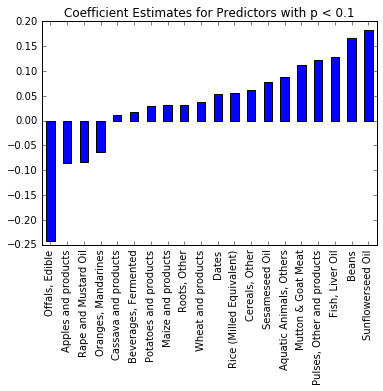

In [16]:
# Set p <= 0.1 to display borderline significant results as well
plot_sig_coeffs(risk_2000_results, 0.1)

### Interpretation
### Statistical Issues
From the summary of the fit, we see that multicollinearity is an issue as expected, so moving forward we will have to address that with variable selection- lasso regression will probably be a good way of dealing with that. Other standard regression diagnostics, such as checking for normality of residuals, homoskedasticity and nonlinearity should be performed as well when fine-tuning our eventual models.

These are the same statistical issues as before, but now the categories (food items) are clean.

Let's fit linear models for the other response variables in the year 2000.

## Deaths per 100k from All Causes as Response Variable

In [17]:
deaths_100k_all_2000_model = sm.OLS(deaths_100k_all_2000.drop(countries_to_drop).sort_index(), food_1970_2000_cleaned.sort_index())
deaths_100k_all_2000_results = deaths_100k_all_2000_model.fit()
print(deaths_100k_all_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     37.94
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           1.47e-38
Time:                        15:08:22   Log-Likelihood:                -925.53
No. Observations:                 154   AIC:                             2015.
Df Residuals:                      72   BIC:                             2264.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

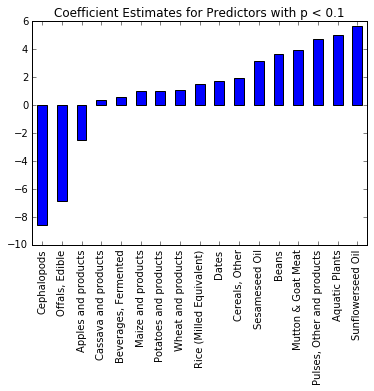

In [18]:
plot_sig_coeffs(deaths_100k_all_2000_results, 0.1)

## Deaths per 100k from Cancer as Response Variable

In [19]:
deaths_100k_cancer_2000_model = sm.OLS(deaths_100k_cancer_2000.drop(countries_to_drop).sort_index(), food_1970_2000_cleaned.sort_index())
deaths_100k_cancer_2000_results = deaths_100k_cancer_2000_model.fit()
print(deaths_100k_cancer_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     24.92
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.27e-32
Time:                        15:09:15   Log-Likelihood:                -703.75
No. Observations:                 154   AIC:                             1571.
Df Residuals:                      72   BIC:                             1821.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

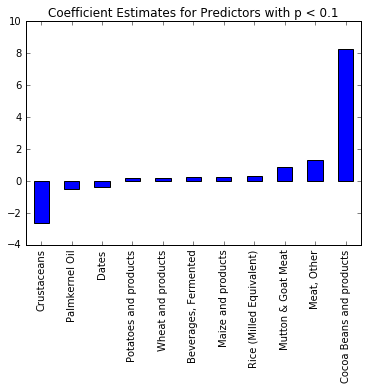

In [20]:
plot_sig_coeffs(deaths_100k_cancer_2000_results, 0.1)

## Deaths per 100k from Cardiovascular Disease as Response Variable

In [21]:
deaths_100k_cardio_2000_model = sm.OLS(deaths_100k_cardio_2000.drop(countries_to_drop).sort_index(), food_1970_2000_cleaned.sort_index())
deaths_100k_cardio_2000_results = deaths_100k_cardio_2000_model.fit()
print(deaths_100k_cardio_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     31.23
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           1.13e-35
Time:                        15:09:36   Log-Likelihood:                -842.08
No. Observations:                 154   AIC:                             1848.
Df Residuals:                      72   BIC:                             2097.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

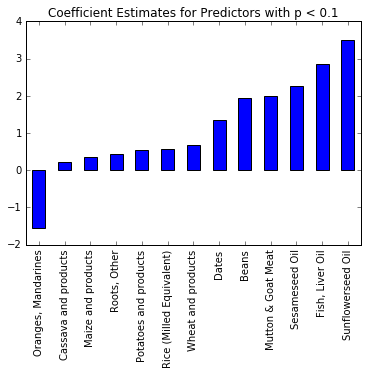

In [22]:
plot_sig_coeffs(deaths_100k_cardio_2000_results, 0.1)

## Deaths per 100k from Diabetes as Response Variable

In [23]:
deaths_100k_diabetes_2000_model = sm.OLS(deaths_100k_diabetes_2000.drop(countries_to_drop).sort_index(), food_1970_2000_cleaned.sort_index())
deaths_100k_diabetes_2000_results = deaths_100k_diabetes_2000_model.fit()
print(deaths_100k_diabetes_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     7.079
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.31e-15
Time:                        15:10:00   Log-Likelihood:                -620.18
No. Observations:                 154   AIC:                             1404.
Df Residuals:                      72   BIC:                             1653.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

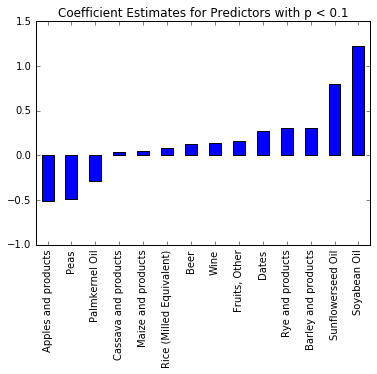

In [24]:
plot_sig_coeffs(deaths_100k_diabetes_2000_results, 0.1)

## Deaths per 100k from Respiratory Disease as Response Variable

In [25]:
deaths_100k_resp_2000_model = sm.OLS(deaths_100k_resp_2000.drop(countries_to_drop).sort_index(), food_1970_2000_cleaned.sort_index())
deaths_100k_resp_2000_results = deaths_100k_resp_2000_model.fit()
print(deaths_100k_resp_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     8.246
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           3.08e-17
Time:                        15:10:27   Log-Likelihood:                -665.61
No. Observations:                 154   AIC:                             1495.
Df Residuals:                      72   BIC:                             1744.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

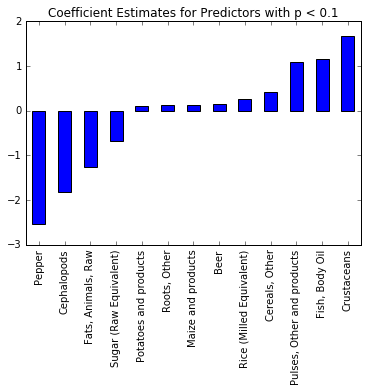

In [26]:
plot_sig_coeffs(deaths_100k_resp_2000_results, 0.1)